# Support Vector Machine Models

**Support vector machines (SVMs)** are a widely used and powerful category of machine learning algorithms. There are many variations on the basic idea of an SVM. An SVM attempts to **maximally seperate** classes by finding the **suport vector** with the lowest error rate or maximum separation. SVMs can use many types of **kernel functions**. The most common kernel functions are **linear** and the **radial basis function** or **RBF**. The linear basis function attempts to separate classes by finding hyperplanes in the feature space that maximally separate classes. The RBF uses set of local Gaussian shaped basis kernels to find a nonlinear separation of the classes. 

## Example: Iris dataset

As a first example you will use SVMs to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [14]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(e1071)
library(MLmetrics)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions


Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall



To get a feel for these data, you will now load and plot them. Execute this code and examine the results. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


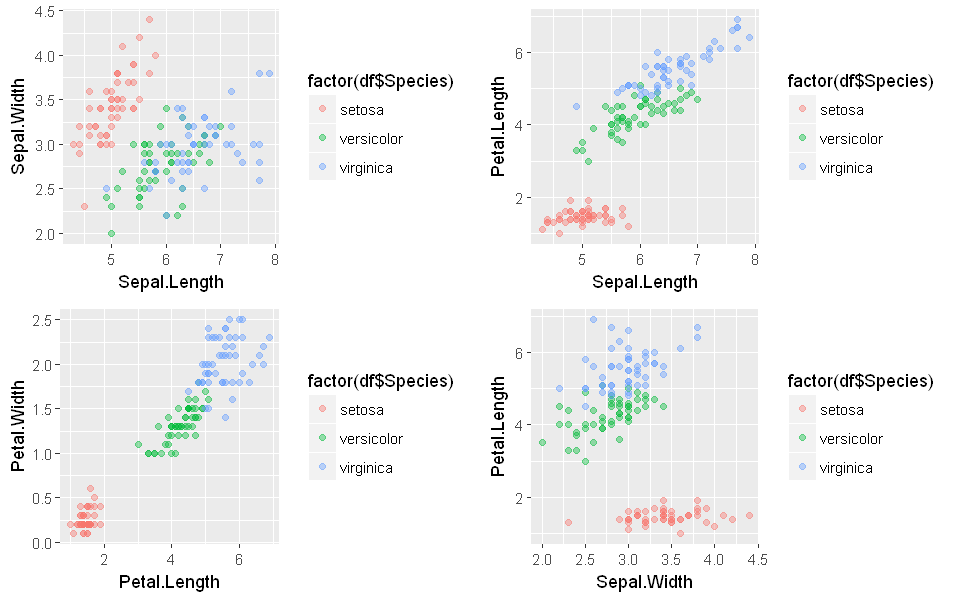

In [2]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris) 

You can see that Setosa (in red) is well separated from the other two categories. The Versicolor (in green) and the Virginica (in blue) show considerable overlap. The question is how well our classifier will separate these categories. 

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 67% of the cases are being used as the test dataset. 

In [3]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.33, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 51  5

[1] 99  5

As is always the case with machine learning, numeric features  must be scaled. Execute the code in the cell below to scale the training and test datasets:

In [4]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


Now you will define and fit an SVM model. The code in the cell uses the `svm` function from the e1071 package. The model formula is specified along with the data, the requirement not to scale and the `type` of model required. Execute this code.

In [5]:
svm_mod = svm(factor(Species) ~ ., data = training, scale = FALSE, type = 'C-classification')

Next, the code in the cell below uses the `predict` method is used to compute the multinomial class probabilities from the scaled features. Execute this code. 

In [6]:
test[,'scores'] = predict(svm_mod, newdata = test)
test[1:10,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,scores
1,-0.78061890,1.17616289,-1.293220,-1.287390,setosa,setosa
2,-1.02263448,-0.02352326,-1.293220,-1.287390,setosa,setosa
4,-1.38565786,0.21641397,-1.238167,-1.287390,setosa,setosa
7,-1.38565786,0.93622566,-1.293220,-1.157633,setosa,setosa
8,-0.90162669,0.93622566,-1.238167,-1.287390,setosa,setosa
12,-1.14364227,0.93622566,-1.183113,-1.287390,setosa,setosa
14,-1.74868124,-0.02352326,-1.458381,-1.417146,setosa,setosa
15,0.06643565,2.37584904,-1.403328,-1.287390,setosa,setosa
16,-0.05457214,3.33559795,-1.238167,-1.027876,setosa,setosa
19,-0.05457214,1.89597458,-1.128059,-1.157633,setosa,setosa


You can see actual species and predicted species. 

It is time to evaluate the model results. Keep in mind that the problem has been made deliberately difficult, by having more test cases than training cases. The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from previous labs to deal with a three category problem. Execute this code and examine the results.

In [7]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')      

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         29         4
  virginica       0          2        31

Accuracy =  0.939 
 
          setosa versicolor virginica
Precision      1      0.879     0.939
Recall         1      0.935     0.886
F1             1      0.906     0.912


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified. 
2. The overll accuracy is 0.94. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 51 cases. 
3. The precision, recall and  F1 for each of the classes is relatively good. Versicolor has the worst metrics since it has the largest number of misclassified cases. 

How important are each of the features for this model? The R Caret package provides the capability to find out. As a first step, `gbm` models must be trained using the the Caret `train` function. The code in the cell below does this, using the default model arguments. The default arguments for the model are specified with the `tuneGrid` argument of `train`. Execute the code.

In [8]:
trControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)

svm_mod_train = train(factor(Species) ~ ., 
                      data = training, 
                      method = "svmLinear", 
                      verbose = FALSE,
                      trControl = trControl,
                      scale = FALSE, 
                      type = 'C-svc')
svm_mod_train

Support Vector Machines with Linear Kernel 

51 samples
 4 predictor
 3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 45, 45, 45, 46, 45, 47, ... 
Resampling results:

  Accuracy   Kappa    
  0.9688889  0.9533088

Tuning parameter 'C' was held constant at a value of 1

With the Caret model object trained, the feature importance can be computed and displayed. Execute this code and examine the results. 

In [9]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(svm_mod_train, scale = FALSE)$importance
imp

,setosa,versicolor,virginica
Sepal.Length,1.0000000,0.9446367,1.0000000
Sepal.Width,0.8961938,0.8961938,0.7283737
Petal.Length,1.0000000,1.0000000,1.0000000
Petal.Width,1.0000000,1.0000000,1.0000000


Examine the table above. Notice that `Sepal.Width` has the least importance for classifying each of the species. 

Execute this code, and answer **Question 1** on the course page.

Next, you will train and evaluate a model using the three most important features by executing the code in the cell below:

In [10]:
svm_mod_3 = svm(factor(Species) ~ Sepal.Length + Petal.Length + Petal.Width, data = training, 
                 scale = FALSE, type = 'C-classification')
test[,'scores'] = predict(svm_mod, newdata = test)
print_metrics(test, 'Species')  

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         29         4
  virginica       0          2        31

Accuracy =  0.939 
 
          setosa versicolor virginica
Precision      1      0.879     0.939
Recall         1      0.935     0.886
F1             1      0.906     0.912


These results are identical to those obtained with the model with all features. The simpler model is preferred since it is likely to generalize better. 

The code in the cell below plots the classes of the iris flower along with the classification errors shown by shape. Execute this code and examine the results.  

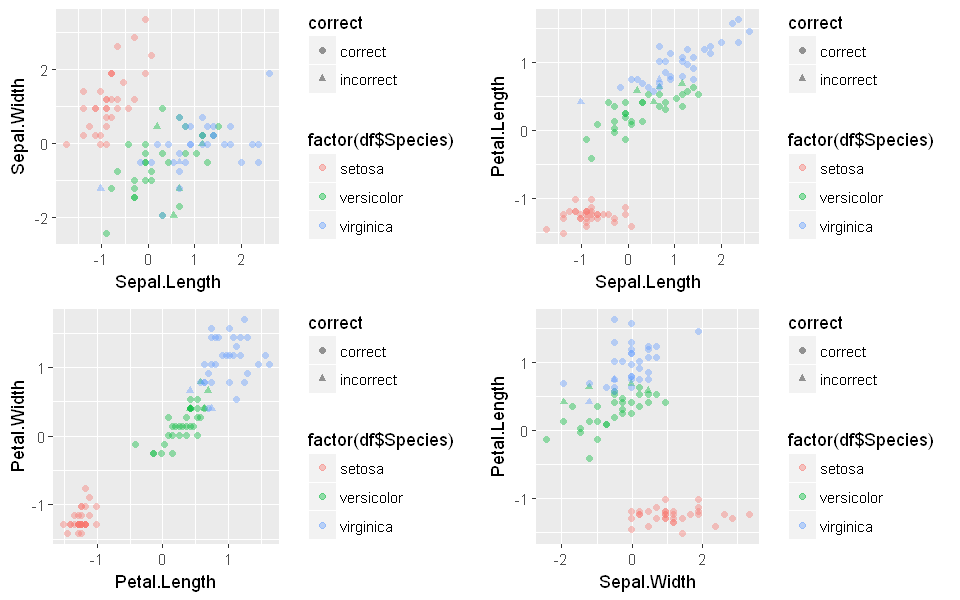

In [11]:
## Create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species), shape = correct), alpha = 0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

plot_iris_classes(test)

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which has been prepared by removing duplicate cases. Some columns which are know not to be predictive are removed. Execute the code in the cell below to load the dataset for the example. 

In [12]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
## Subset the data frame
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount', 'savings_account_balance',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 'age_yrs',
                   'other_credit_outstanding', 'number_loans', 'job_category', 'dependents', 'telephone', 'bad_credit' )]
print(dim(credit))
names(credit)

[1] 999  16


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "savings_account_balance"  "time_employed_yrs"       
 [7] "payment_pcnt_income"      "time_in_residence"       
 [9] "property"                 "age_yrs"                 
[11] "other_credit_outstanding" "number_loans"            
[13] "job_category"             "dependents"              
[15] "telephone"                "bad_credit"

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [13]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2464282,0.9483849,-0.86876113,-0.7645835,-1.19202026,-0.7035652,-0.4283287
-0.7397312,-0.4170067,-0.86876113,0.1414888,1.18945982,-0.7035652,2.3323187
1.7487350,1.6323204,-0.86876113,1.0475610,0.83664795,-0.7035652,2.3323187
0.2556552,0.5655086,0.02505181,1.0475610,1.54227168,1.0276211,2.3323187
1.2510417,2.0477820,-0.86876113,1.0475610,-0.04538171,-0.7035652,2.3323187
0.2556552,-0.1552623,0.02505181,1.0475610,1.54227168,-0.7035652,-0.4283287


The R Caret package computes most performance metrics using the positive cases. For example, recall is a measure of correct classification of positive cases. Therefore, it is important to have the coding of the label correct. The code in the cell below creates a factor (categorical) variable and coerces the levels of the label column, `bad_credit`. Execute this code. 

In [15]:
credit$bad_credit <- ifelse(credit$bad_credit == 0, 'good', 'bad')
credit$bad_credit <- factor(credit$bad_credit, levels = c("bad", "good"))
credit$bad_credit[1:5]

[1] bad  good good bad  good
Levels: bad good

In the results above you can see the new coding of the label column along with the levels, {'bad', 'good'}. 

As the inner loop of a nested cross validation, the code in the cell below uses the capability of the R Caret package to estimate the best hyperparameters using 5 fold cross validation. This first cross validation is performed using ROC as the metric. There are a few points to note here:
1. A Caret `trainControl` object is used to define the 5 fold cross validation. The `twoClassSummary` function is specified, making ROC the metric for hyperparameter optimization. The `svmRadial` model does accommodate case weights. However, in the case **down-sampling** or **down-sampling** is used. Down-sampling randomly samples the majority case so that the number of classes in each training fold is balanced. 
2. The model is trained using all features as can be seen from the model formula in the Caret `train` function. 
3. `ROC` is specified as a `metric` in the call to `train`. 
4. Weights are specified to help with the class imbalance and the cost imbalance of misclassification of bad credit customers. 
5. The `train` function uses a `tuneGrid` argument to define the hyperparameters to search. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [27]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'down',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)
paramGrid <- expand.grid(sigma = c(0.002, 0.02, 0.2), C = c(0.5, 1.0, 2.0))

set.seed(1234)
svm_fit_inside_tw <- train(bad_credit ~ ., 
                          data = credit,  
                          method = "svmRadial", # Radil SVM model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          metric="ROC")
print(svm_fit_inside_tw)

Support Vector Machines with Radial Basis Function Kernel 

999 samples
 15 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 799, 799, 799 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  sigma  C    ROC        Sens       Spec     
  0.002  0.5  0.7594322  0.7733333  0.6237513
  0.002  1.0  0.7575188  0.7433333  0.6494758
  0.002  2.0  0.7676112  0.7500000  0.6681398
  0.020  0.5  0.7729234  0.7500000  0.6695889
  0.020  1.0  0.7776586  0.7266667  0.6694964
  0.020  2.0  0.7617850  0.7133333  0.6681192
  0.200  0.5  0.7032055  0.4566667  0.7325694
  0.200  1.0  0.7051631  0.6100000  0.6724358
  0.200  2.0  0.7019918  0.6900000  0.6224769

ROC was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.02 and C = 1.


The grid of hyperpameters searched by the Caret package is over kernel span parameter `sigma` and cost parameter `C`. The grid along with the ROC and other metrics is shown in the printed table. 

The hyperparameter optimization can also be performed using Recall as a metric. The code in the cell below uses the `prSummary` function for the `summaryFunction` argument for `trainControl` and sets the `metric` as `Recall`. Execute this call and examine the results.    

In [28]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'down',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = prSummary)
paramGrid <- expand.grid(sigma = c(0.002, 0.02, 0.2), C = c(0.5, 1.0, 2.0))

set.seed(1234)
svm_fit_inside_pr <- train(bad_credit ~ ., 
                          data = credit,  
                          method = "svmRadial", # Radil SVM model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          metric="Recall")
print(svm_fit_inside_pr)

Support Vector Machines with Radial Basis Function Kernel 

999 samples
 15 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 799, 799, 799 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  sigma  C    AUC        Precision  Recall     F        
  0.002  0.5  0.5320865  0.4711544  0.7733333  0.5846217
  0.002  1.0  0.5280346  0.4787061  0.7433333  0.5814881
  0.002  2.0  0.5478869  0.4933955  0.7500000  0.5946419
  0.020  0.5  0.5582512  0.4972203  0.7500000  0.5962507
  0.020  1.0  0.5744037  0.4883108  0.7266667  0.5828072
  0.020  2.0  0.5329558  0.4820181  0.7133333  0.5735516
  0.200  0.5  0.4588505  0.4667378  0.4566667  0.4268263
  0.200  1.0  0.4529458  0.4575720  0.6100000  0.5102596
  0.200  2.0  0.4653013  0.4425277  0.6900000  0.5354460

Recall was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.00

These resutls are rather poor. The AUC is barely above 0.5. It is best to stay with the model trained on ROC. 

Given the optimal hyperparameters for the model trained with ROC, which features are the most important? The code in the cell below computes and displays feature importance using the Caret `varImp` function. Execute this code and examine the results. 

ROC curve variable importance

                         Importance
checking_account_status    100.0000
loan_duration_mo            65.4957
savings_account_balance     46.3343
age_yrs                     35.5070
credit_history              28.9269
loan_amount                 27.4488
payment_pcnt_income         21.9452
time_employed_yrs           18.0996
number_loans                12.0787
other_credit_outstanding    12.0442
job_category                 9.6521
telephone                    9.1976
property                     6.7821
time_in_residence            0.3313
dependents                   0.0000


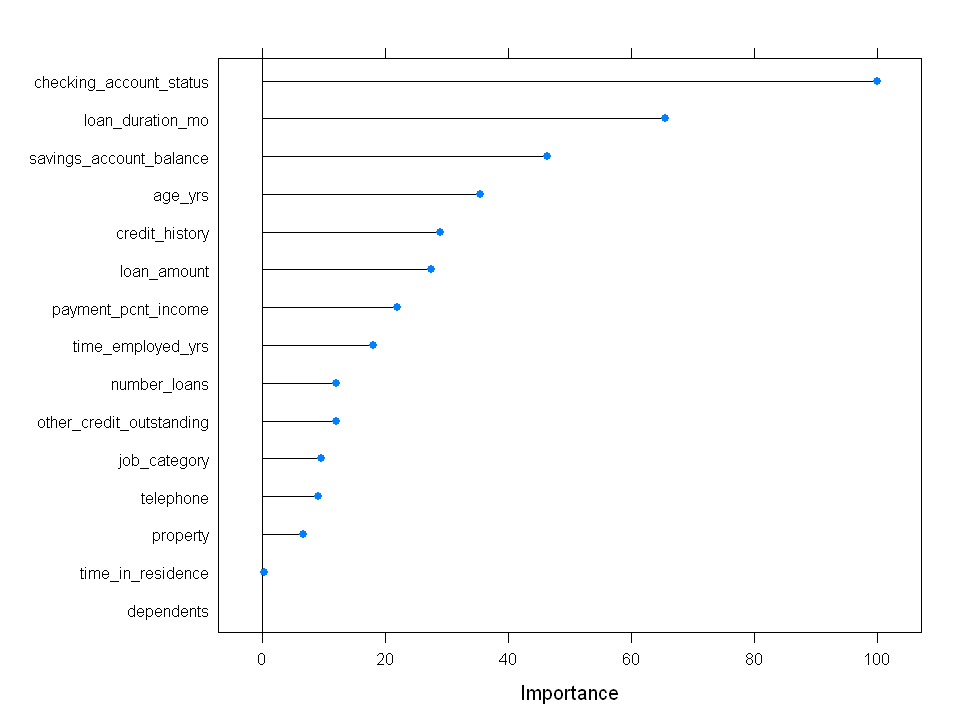

In [29]:
options(repr.plot.width=8, repr.plot.height=6)
var_imp = varImp(svm_fit_inside_tw)
print(var_imp)
plot(var_imp)

It is clear that at least two of the features should be removed from the dataset. Execute the code in the cell below to use the dplyr `select` function to remove two features.

In [30]:
credit_reduced = select(credit, -time_in_residence, -dependents)

Execute the code in the cell below to perform the cross validation grid search using ROC as the metric with the reduced feature set: 

In [31]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'down',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)
paramGrid <- expand.grid(sigma = c(0.002, 0.02, 0.2), C = c(0.5, 1.0, 2.0))

set.seed(1234)
svm_fit_inside_tw <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "svmRadial", # Radil SVM model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          metric="ROC")
print(svm_fit_inside_tw)

Support Vector Machines with Radial Basis Function Kernel 

999 samples
 13 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 799, 799, 799 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  sigma  C    ROC        Sens       Spec     
  0.002  0.5  0.7600973  0.7566667  0.6294656
  0.002  1.0  0.7582854  0.7466667  0.6509044
  0.002  2.0  0.7689226  0.7466667  0.6552518
  0.020  0.5  0.7722736  0.7533333  0.6724358
  0.020  1.0  0.7804495  0.7433333  0.6738027
  0.020  2.0  0.7649697  0.7233333  0.6752724
  0.200  0.5  0.7154683  0.6466667  0.6480576
  0.200  1.0  0.7045682  0.6100000  0.6666598
  0.200  2.0  0.6952859  0.6600000  0.6280370

ROC was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.02 and C = 1.


The results of the cross validation grid search with the reduced feature set are nearly the same as the first result. Evidentially, pruning these features was the correct step. This process can be continued, but will not be in this lab in the interest of reducing length. 

To better understand the parameter sweep, execute the code in the cell below to create a chart.

ROC curve variable importance

                         Importance
checking_account_status     100.000
loan_duration_mo             62.985
savings_account_balance      42.430
age_yrs                      30.815
credit_history               23.756
loan_amount                  22.170
payment_pcnt_income          16.266
time_employed_yrs            12.141
number_loans                  5.682
other_credit_outstanding      5.645
job_category                  3.079
telephone                     2.591
property                      0.000


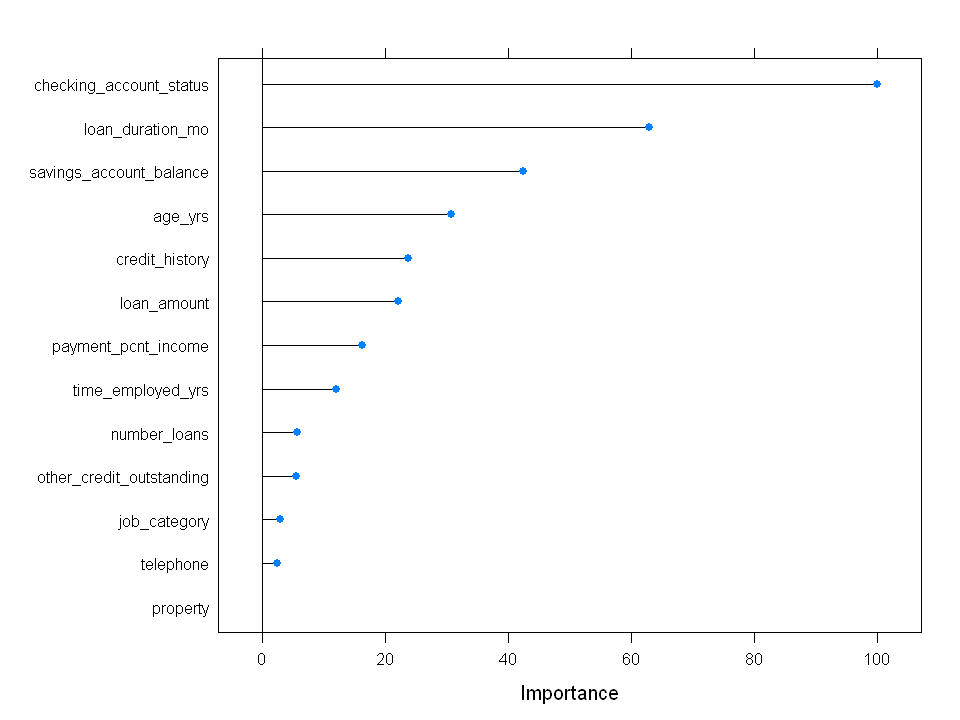

In [32]:
options(repr.plot.width=8, repr.plot.height=6)
var_imp = varImp(svm_fit_inside_tw)
print(var_imp)
plot(var_imp)

In is clear that some of the features are not important to model performance. Execute the code in the cell below to prune the feature set using the dplyr `seelct` function:

In [33]:
credit_reduced = select(credit, -telephone, -property, -job_category)

Execute the code in the cell below to perform the cross validation grid search using the reduced feature set and the ROC metric: 

In [34]:
fitControl <- trainControl(method = "cv",
                           number = 5,
                           sampling = 'down',
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)
paramGrid <- expand.grid(sigma = c(0.002, 0.02, 0.2), C = c(0.5, 1.0, 2.0))

set.seed(1234)
svm_fit_inside_tw <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "svmRadial", # Radil SVM model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          metric="ROC")
print(svm_fit_inside_tw)

Support Vector Machines with Radial Basis Function Kernel 

999 samples
 12 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 799, 799, 799, 799 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  sigma  C    ROC        Sens       Spec     
  0.002  0.5  0.7541165  0.7866667  0.6209147
  0.002  1.0  0.7535454  0.7566667  0.6423433
  0.002  2.0  0.7724243  0.7600000  0.6495581
  0.020  0.5  0.7702006  0.7633333  0.6581295
  0.020  1.0  0.7727311  0.7366667  0.6480781
  0.020  2.0  0.7575826  0.7300000  0.6623638
  0.200  0.5  0.6955829  0.6866667  0.5664440
  0.200  1.0  0.6898177  0.5533333  0.6595786
  0.200  2.0  0.6815087  0.6366667  0.6136793

ROC was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.02 and C = 1.


The results of the cross validation grid search with the reduced feature set are nearly the same as the first result. Evidentially, pruning these features was the correct step. This process can be continued, but will not be in this lab in the interest of reducing length. 

To better understand the parameter sweep, execute the code in the cell below to create a chart.

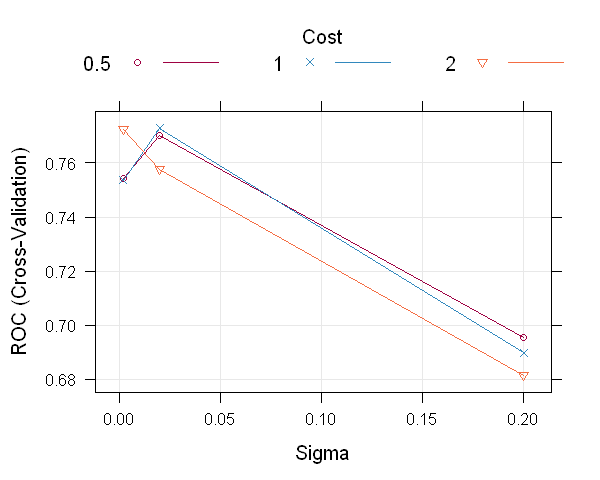

In [35]:
options(repr.plot.width=5, repr.plot.height=4)
trellis.par.set(caretTheme())
plot(svm_fit_inside_tw)  

Notice that at the low end of the range of sigma values none of the cost values really matter. It is often the case with model selection that only one or two hyperparameters have much of an effect. 

Finally, to verify that the model will generalize well it is time to perform the outside CV loop. The code in the cell below defines a parameter grid with just the optimal hyperparameter values. The CV then repeatedly fits the model with this single hyperparameter. Execute this code and examine the result.

In [36]:
paramGrid <- expand.grid(sigma = c(0.02), C = c(1))

set.seed(1234)
svm_fit_outside_tw <- train(bad_credit ~ ., 
                          data = credit_reduced,  
                          method = "svmRadial", # Radial SVM model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          weights = weights, 
                          trace = FALSE,
                          metric="ROC")

print_metrics = function(mod){
    means = c(apply(mod$resample[,1:3], 2, mean), sigma = mod$resample[1,4], C = mod$resample[1,5], Resample = 'Mean')
    stds = c(apply(mod$resample[,1:3], 2, sd), sigma = mod$resample[1,4], C = mod$resample[1,5], Resample = 'STD')
    out = rbind(mod$resample, means, stds)
    out[,1:3] = lapply(out[,1:3], function(x) round(as.numeric(x), 3))
    out
}
print_metrics(svm_fit_outside_tw)

ROC,Sens,Spec,sigma,C,Resample
0.787,0.717,0.676,0.02,1,Fold1
0.755,0.817,0.557,0.02,1,Fold2
0.776,0.733,0.643,0.02,1,Fold3
0.765,0.750,0.679,0.02,1,Fold4
0.767,0.583,0.736,0.02,1,Fold5
0.770,0.720,0.658,0.02,1,Mean
0.012,0.085,0.066,0.02,1,STD


Examine these results. Notice that the standard deviation of the mean of the AUC are nearly an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

***
**Note:** The predict method can be used with this optimal model to classify unknown cases.
***

## Summary

In this lab you have accomplished the following:
1. Used a radial support vector machine to classify the cases of the iris data. This model produced quite good results. 
2. Used 5 fold to find estimated optimal hyperparameters for an svmRadial model to classify credit risk cases. The model trained using ROC as the metric performed reasonably well.
3. Applied down-sampling of the majority cases to create a balanced training dataset and retrained and evaluated the model. 
4. Applied feature importance was used for feature selection. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features. 
5. Used the outer loop of the nested cross validation to demonstrate that the model is likely to generalize.